In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')
adata

AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable_rank', 'variances', 'variances_norm'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw'
    obsp: 'connectivities', 'distances'

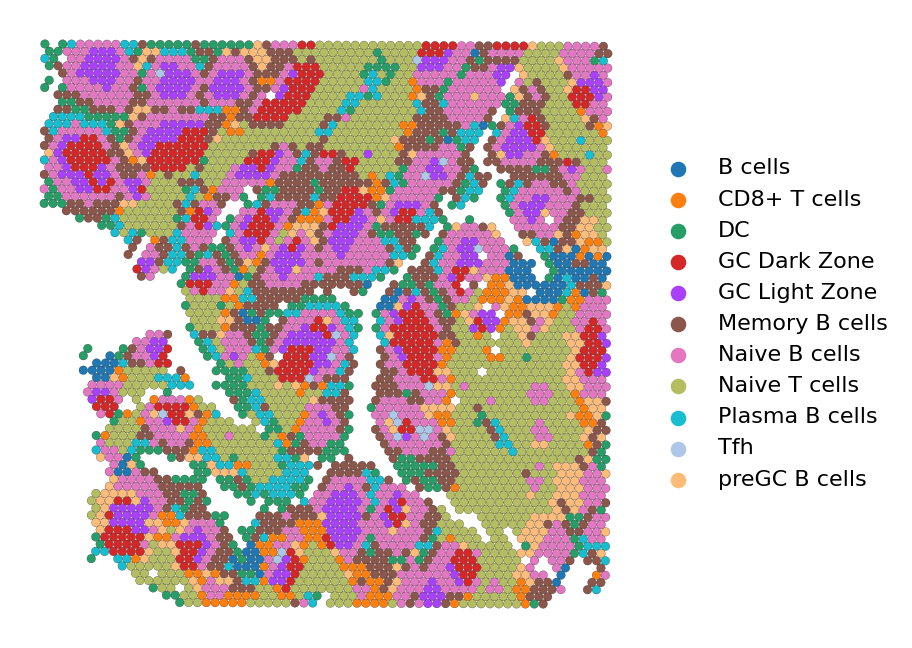

In [4]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=60, linewidth=0.1, title='')

In [5]:
adata.obs['cell_type'].value_counts()

cell_type
Naive T cells     915
Naive B cells     867
Memory B cells    657
GC Light Zone     327
DC                326
GC Dark Zone      318
preGC B cells     246
Plasma B cells    235
CD8+ T cells      200
B cells            85
Tfh                18
Name: count, dtype: int64

In [6]:
import sys
sys.path.append('../../src/')

In [7]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [8]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 1min 21s, sys: 2min 31s, total: 3min 53s
Wall time: 30.3 s


In [9]:
adata.X.max()

8.370063

In [10]:
adata

AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw'
    obsp: 'connectivities', 'distances'

In [11]:
adata.layers["raw"].max()

21025.0

In [12]:
oracle = co.Oracle()

adata.X = adata.layers["raw"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

4053 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


In [13]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [14]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 11/11 [18:48<00:00, 102.58s/it]

CPU times: user 11min 56s, sys: 27.9 s, total: 12min 24s
Wall time: 18min 48s


In [15]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
import pickle

with open('/Volumes/SSD/training_data/human_tonsil_proteomics_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [17]:
adata.write_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')